In [1]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import networkx as nx
import torch.optim as optim
import matplotlib.pyplot as plt
from gn_models import init_graph_features, FFGN
import torch
from tensorboardX import SummaryWriter
from datetime import datetime
import os
import sys
from scipy.stats import pearsonr
from train_gn import SwimmerDataset
from PIL import Image
import imageio
from utils import *
import argparse
%matplotlib inline

In [2]:
def evaluate_graph_loss(G, state, last_state):
    n_nodes = len(G)

    dpos = state[:, 5:5 + 18].view(-1, 6, 3)
    dvel = state[:, 5+18:5 + 18+18].view(-1, 6, 3)

    last_pos = last_state[:, 5:5 + 18].view(-1, 6, 3)
    vel = state[:, 5 + 18:5 + 36].view(-1, 6, 3)
    mean = 0

    true = []
    pred = []

    for node in G.nodes():
        #print(node)
        #loss += torch.mean((G.nodes[node]['feat'][:,:3] - pos[:,node]) ** 2)
        #loss += torch.mean((G.nodes[node]['feat'][:, 3:] - vel[:, node]) ** 2)
        mean += torch.mean(torch.abs((G.nodes[node]['feat'][:,:3] - dpos[:,node]) / dpos[:,node] ))
        pred.append(G.nodes[node]['feat'][:,:3])
        true.append(dpos[:,node])
        
        pred.append(G.nodes[node]['feat'][:,3:])
        true.append(dvel[:,node])
        
        

    pred = torch.stack(pred).view(-1,1)
    true = torch.stack(true).view(-1,1)

    plt.figure()
    for node in G.nodes():
        pos = last_pos[0, node, :3].cpu().data.numpy()

        angle = pos[2]
        x = pos[0]
        y = pos[1]
        r = 0.05
        dy = np.cos(angle) * r
        dx = - np.sin(angle) * r
        # plt.figure()
        plt.plot([x - dx, x + dx], [y - dy, y + dy], 'g', alpha = 0.5)

        pos = G.nodes[node]['feat'][0,:3].cpu().data.numpy() + last_pos[0,node,:3].cpu().data.numpy()
        angle = pos[2]
        x = pos[0]
        y = pos[1]
        r = 0.05
        dy = np.cos(angle) * r
        dx = - np.sin(angle) * r
        # plt.figure()
        plt.plot([x - dx, x + dx], [y - dy, y + dy],'r', alpha = 0.5)
        pos = dpos[0,node].cpu().data.numpy() + last_pos[0, node, :3].cpu().data.numpy()

        angle = pos[2]
        x = pos[0]
        y = pos[1]
        r = 0.05
        dy = np.cos(angle) * r
        dx = - np.sin(angle) * r
        # plt.figure()
        plt.plot([x - dx, x + dx], [y - dy, y + dy],'b', alpha = 0.5)
    plt.axis('equal')
    #plt.show()

    mean /= n_nodes

    return mean.data.item(), true, pred

In [3]:
def get_graph_features(G, bs = 1):
    state = torch.zeros((bs, 41)).cuda()
    
    #joints = state[:,:5]
    pos = torch.zeros((bs, 6, 3)).cuda()
    vel = torch.zeros((bs, 6, 3)).cuda()
    
    # only get node features
    for node in G.nodes():
        #print(node)
        pos[:,node] = G.nodes[node]['feat'][:,:3]
        vel[:, node] = G.nodes[node]['feat'][:, 3:]

        
    state[:, 5:5+18] = pos.view(-1, 18)
    state[:, 5+18:5+36] = pos.view(-1,18)
    return state


In [4]:
model_fn = '/home/fei/Development/physics_predmodel/gn/logs/runs/October01_14:59:16/model_1240000.pth'
dset = SwimmerDataset('swimmer_test.npy')
use_cuda = True
dl = DataLoader(dset, batch_size=200, num_workers=0, drop_last=True)
node_feat_size = 6
edge_feat_size = 3
graph_feat_size = 10
gn = FFGN(graph_feat_size, node_feat_size, edge_feat_size).cuda()
gn.load_state_dict(torch.load(model_fn))

normalizers = torch.load('normalize.pth')
in_normalizer = normalizers['in_normalizer']
out_normalizer = normalizers['out_normalizer']

In [5]:
G1 = nx.path_graph(6).to_directed()

In [6]:
dl_e = enumerate(dl)

In [11]:
data = dset.__get_episode__(360)
data = [torch.from_numpy(item) for item in data]

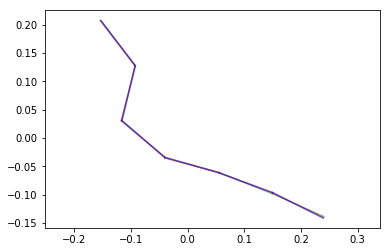

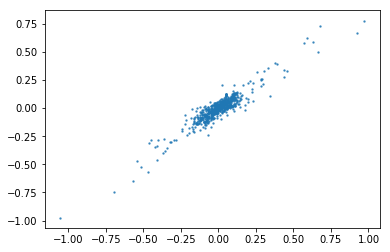

In [12]:
action, delta_state, last_state = data
action, delta_state, last_state = action.float(), delta_state.float(), last_state.float()

if use_cuda:
    action, delta_state, last_state = action.cuda(), delta_state.cuda(), last_state.cuda()


init_graph_features(G1, graph_feat_size, node_feat_size, edge_feat_size, cuda=True, bs = 100)
load_graph_features(G1, action, last_state, None,bs=100, noise = 0)
G_out = gn(in_normalizer.normalize(G1))
G_out = out_normalizer.inormalize(G_out)
loss, true, pred = evaluate_graph_loss(G_out, delta_state, last_state)

true = true.data.cpu().numpy()
pred = pred.data.cpu().numpy()

plt.figure()
plt.scatter(true, pred, s = 2, alpha = 0.7)

In [13]:
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    plt.close()
    return np.array(Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) ) )

def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf

def draw_state(state):
    state = state.cpu().data.numpy()[0]
    positions = state[5:5+18].reshape(6,3)
 
    fig = plt.figure()

    for node in range(6):
        pos = positions[node]
        angle = pos[2]
        x = pos[0]
        y = pos[1]
        r = 0.05
        dy = np.cos(angle) * r
        dx = - np.sin(angle) * r
        plt.plot([x - dx, x + dx], [y - dy, y + dy], 'g', alpha = 0.5)

        plt.axis('equal')
        
    
    img = fig2img(fig)
    plt.close()    
    return img

In [14]:
writer = imageio.get_writer('test_pred2.mp4', fps=6)
action, delta_state, last_state = data
action, delta_state, last_state = action.float(), delta_state.float(), last_state.float()

if use_cuda:
    action, delta_state, last_state = action.cuda(), delta_state.cuda(), last_state.cuda()
    
state = last_state[1].unsqueeze(0)
state_gt = last_state[1].unsqueeze(0).clone()

for i in range(1, 50):
    print(i)
    action_i = action[i].unsqueeze(0)
    delta_state_i = delta_state[i].unsqueeze(0)
    last_state_i = last_state[i].unsqueeze(0)
    
    init_graph_features(G1, graph_feat_size, node_feat_size, edge_feat_size, cuda=True, bs = 1)
    load_graph_features(G1, action_i, state, None, bs=1, noise = 0)
    G_out = gn(in_normalizer.normalize(G1))
    G_out = out_normalizer.inormalize(G_out)
    
    delta_state_pred = get_graph_features(G_out)
    
    state_gt += delta_state_i
    state += delta_state_pred

    img = draw_state(state_gt)
    img_pred = draw_state(state)
    
    writer.append_data(np.concatenate([img, img_pred], axis = 1))

writer.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
